# Weighted ECM clustering vs Traditional ECM clustering
## With WINE dataset

In [1]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.wecm_new import wecm
from evclust.utils import ev_plot, ev_pcaplot, calculate_non_specificity, plotting
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


   Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0    14.23       1.71  2.43               15.6        127           2.80   
1    13.20       1.78  2.14               11.2        100           2.65   
2    13.16       2.36  2.67               18.6        101           2.80   
3    14.37       1.95  2.50               16.8        113           3.85   
4    13.24       2.59  2.87               21.0        118           2.80   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   0D280_0D315_of_diluted_wines  Proline  
0                        

D:\vtdo\projects\evclust\src\evclust\utils.py:1085: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_reduced[i, 0], data_reduced[i, 1], alpha=0.5, c=colors[i], marker=marker_list[i])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


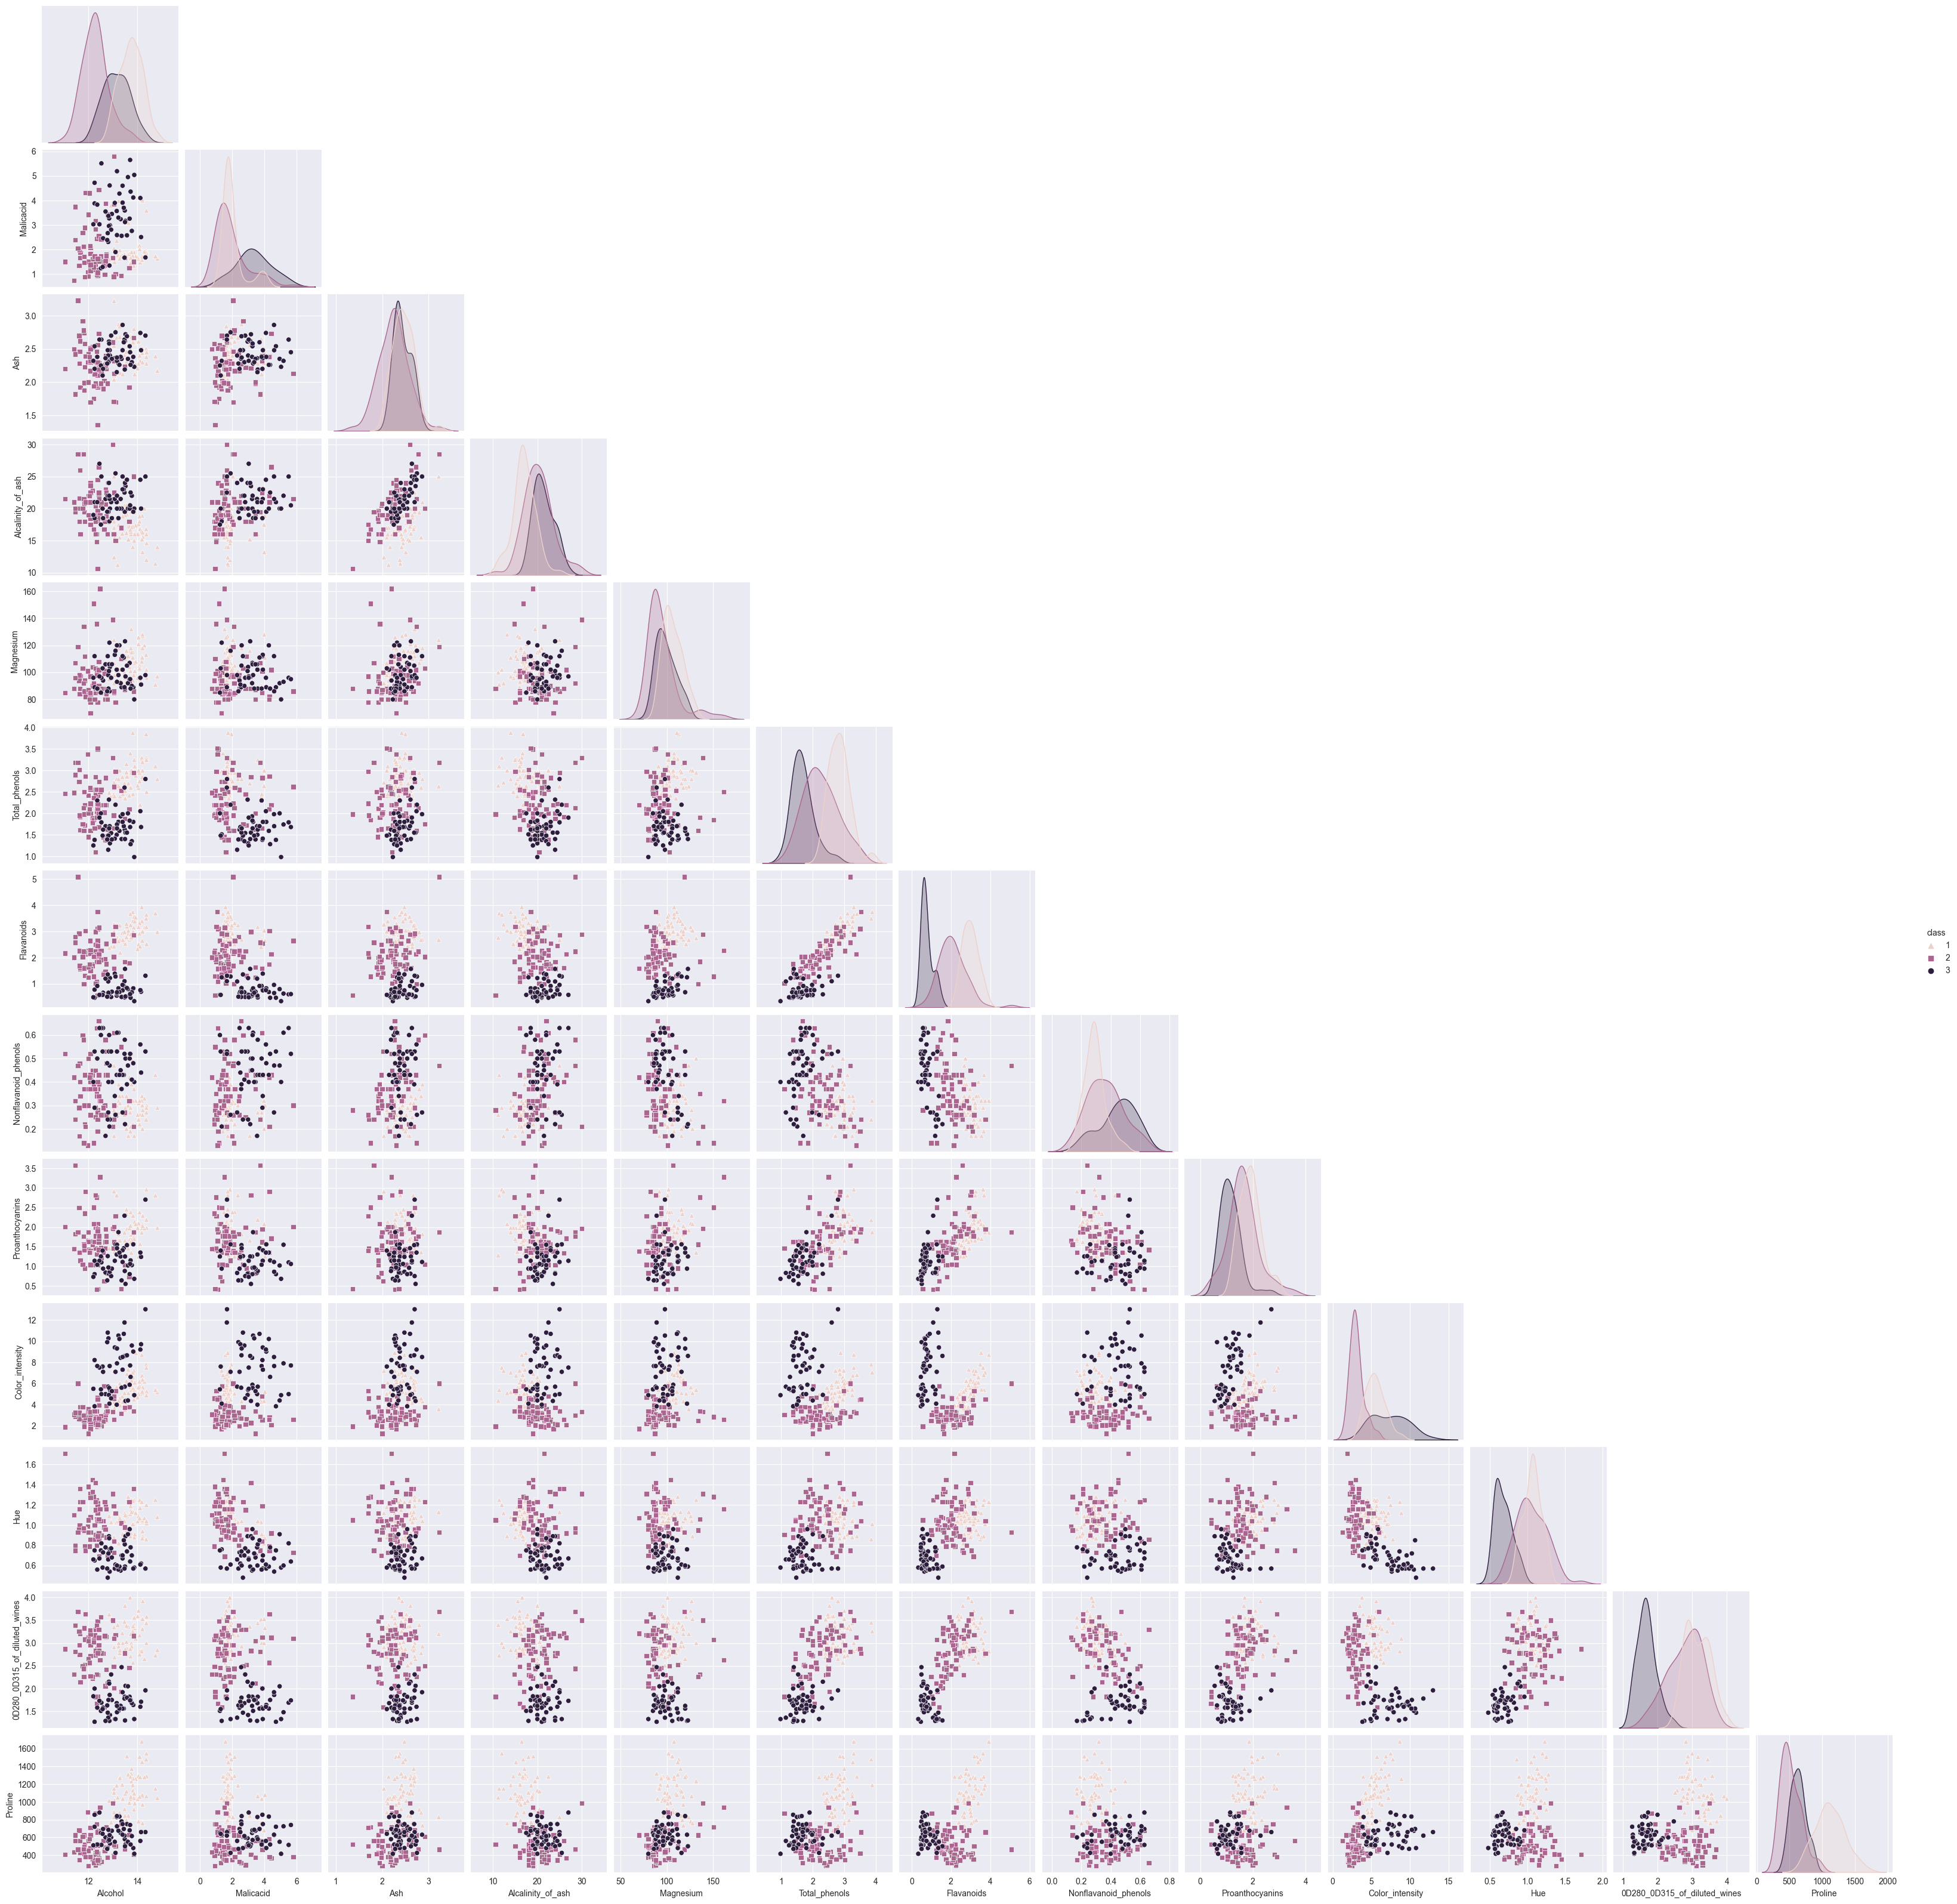

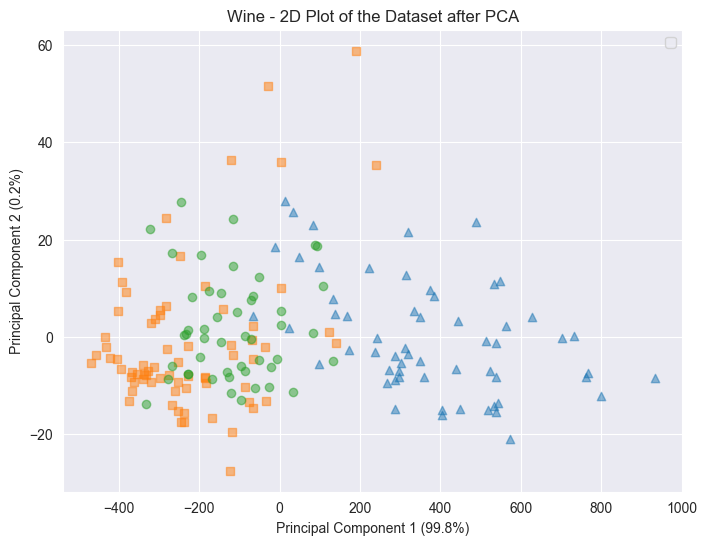

In [18]:
# fetch dataset
iris = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X = pd.DataFrame(iris.data.features)
y = pd.DataFrame(iris.data.targets)

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, ds_name="Wine", matrix_plot=True, markers=markers)

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

In [3]:
%%capture
# Traditional ECM clustering
c=3
delta = np.sqrt(20)
model_list = np.array([])
for i in range(10):
    model = ecm(x=X, c=c, beta=2, alpha=1, delta=delta, init="kmeans")
    model_list = np.append(model_list, model)
    
model_list = sorted(model_list, key=lambda x : x['crit'])
# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda mod: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

J values: [17.982198145134515, 17.982198145134515, 17.982198145134515, 17.982198145134515, 17.982198145134518, 17.982198145134518, 17.98223139503376, 17.982300224925165, 17.982300224925165, 17.982392350590406]
ARI values: [0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465]
NS values: [1.4094946927566254, 1.4094946927566254, 1.3800419619837736, 1.4094946927566254, 1.4163427337728927, 1.4163427337728927, 1.3843930489090783, 1.3682307249821892, 1.3842724777087116, 1.4164299147130197]
NMI values: [0.8215490461307171, 0.8215490461307171, 0.8215490461307171, 0.8215490461307171, 0.8215490461307171, 0.8215490461307171, 0.8215490461307171, 0.8215490461307171, 0.8215490461307171, 0.8215490461307171]
Average ARI values: 0.8348940044607465
Average Non-specificity: 1.3994537674112433
Average Normalized mutual infor: 0.8215490461307171
Center: [[0.53335

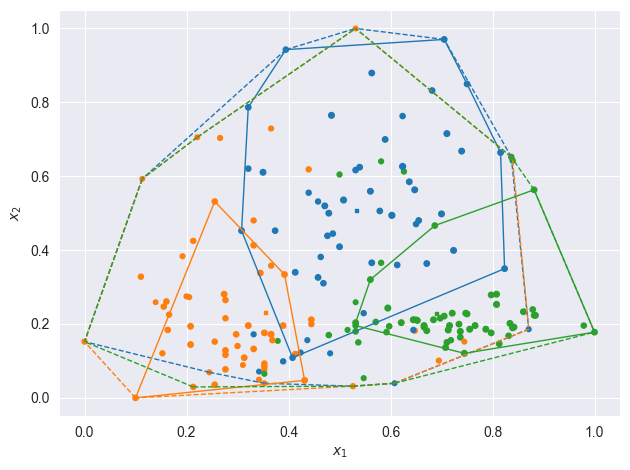

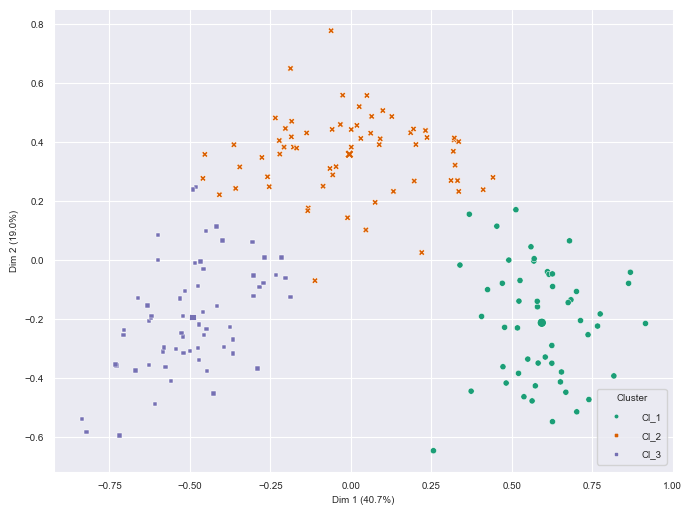

In [4]:
print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")
print(f"Center: {model_list[0]['g']}")
# Plotting the the model with the minimum J value
ev_plot(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)

## Weighted ECM (WECM)

In [15]:
%%capture
model_list = np.array([])
c = 3
d = X.shape[1]
delta=np.sqrt(20)
W = np.ones((c, d)) * (1/d)
for i in range(10):
    model = wecm(x=X, c=c, W=W, beta=2, alpha=1, delta=delta, ntrials=1, epsi=1e-3, init="kmeans", stopping_factor="center")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda mod: model['crit'])

# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda mod: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

J values: [0.09855362022242886, 0.09854590351000697, 0.09854295469836027, 0.10074182134395876, 0.09855362022242888, 0.098545903510007, 0.10074182134395876, 0.09854590351000697, 0.09854590351000697, 0.09855362022242886]
ARI values: [0.7881673809541347, 0.7881673809541347, 0.7881673809541347, 0.7881673809541347, 0.7881673809541347, 0.7881673809541347, 0.7881673809541347, 0.7881673809541347, 0.7881673809541347, 0.7881673809541347]
NS values: [1.391391448264384, 1.3827726008302295, 1.3722778277253442, 1.3861007425650353, 1.3522192868563483, 1.3701562681043364, 1.3949348639403487, 1.3912104955996927, 1.3721984392145978, 1.3700090006291927]
NMI values: [0.784395474761121, 0.784395474761121, 0.784395474761121, 0.784395474761121, 0.784395474761121, 0.784395474761121, 0.784395474761121, 0.784395474761121, 0.784395474761121, 0.784395474761121]
Average ARI values: 0.7881673809541347
Average Non-specificity: 1.378327097372951
Average Normalized mutual infor: 0.784395474761121


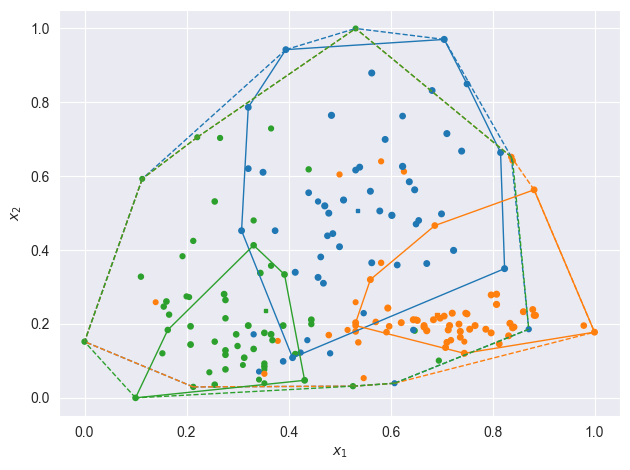

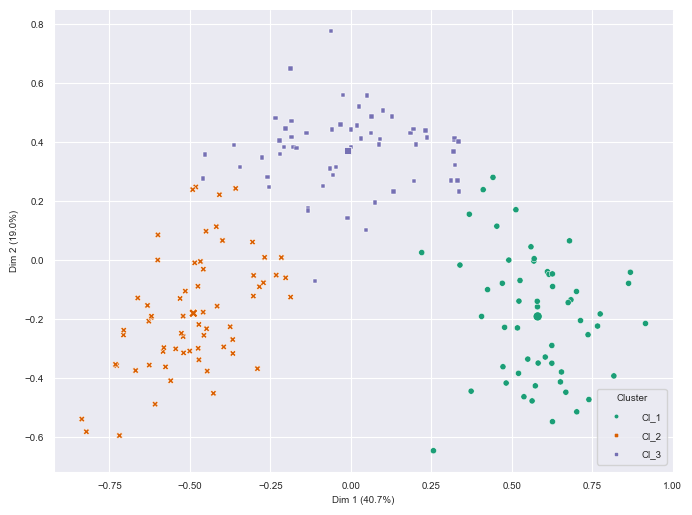

In [16]:
print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")

# Plotting
ev_plot(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)

In [17]:
top_weights = [model['W'] for model in model_list]
for W in top_weights:
    print(f"\n{W}")


[[0.07485039 0.04591034 0.09768889 0.08973689 0.09091688 0.08234142
  0.08946524 0.04583784 0.08620644 0.05153421 0.08251199 0.06753997
  0.09545953]
 [0.06177055 0.08311446 0.088842   0.07688459 0.08382451 0.07648794
  0.08741224 0.07297333 0.07938864 0.08519753 0.09176631 0.06612264
  0.04621528]
 [0.07240514 0.06711808 0.08353289 0.08205238 0.08642084 0.07450775
  0.08667341 0.05869716 0.08151538 0.08943355 0.07662238 0.06228463
  0.07873643]]

[[0.07475687 0.04577669 0.09767031 0.08974181 0.09091815 0.08245569
  0.08964402 0.04571965 0.08625216 0.05137645 0.08247772 0.06757719
  0.09563328]
 [0.07232482 0.06717595 0.08343621 0.08197948 0.08639338 0.07448603
  0.08672844 0.05876212 0.08149956 0.08962722 0.07660726 0.06235489
  0.07862465]
 [0.06201652 0.08309899 0.08889162 0.07700124 0.08383446 0.07638343
  0.08726019 0.07287837 0.07931338 0.08513545 0.09170796 0.06609394
  0.04638446]]

[[0.07225168 0.06707476 0.0834302  0.08196597 0.08642867 0.07457055
  0.08671417 0.05891672 0.0